In [42]:
import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [44]:
def make_transform(size=(64,64)):
    return transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ])

class RelabeledDataset(Dataset):
    def __init__(self, base, mapping, keep_names=None):
        self.base = base
        if keep_names is None:
            self.indices = list(range(len(base.samples)))
        else:
            keep = set(keep_names)
            self.indices = [i for i,(_,y) in enumerate(base.samples) if base.classes[y] in keep]
        self.mapping = mapping
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        x, y = self.base[self.indices[idx]]
        return x, self.mapping[y]

def build_binary_dataset(root, keep=("Forest","Residential"), size=(64,64)):
    base = datasets.ImageFolder(root, transform=make_transform(size))
    mapping = {base.class_to_idx[keep[0]]:0, base.class_to_idx[keep[1]]:1}
    ds = RelabeledDataset(base, mapping, keep_names=keep)
    return ds, base, mapping

def relabel_imagefolder(root, mapping, size=(64,64)):
    base = datasets.ImageFolder(root, transform=make_transform(size))
    ds = RelabeledDataset(base, mapping, keep_names=None)
    return ds, base

def make_loaders(dataset, batch_size=32, val_ratio=0.2, seed=42, num_workers=0):
    g = torch.Generator().manual_seed(seed)
    n = len(dataset)
    n_train = int((1 - val_ratio) * n)
    n_val = n - n_train
    train_ds, val_ds = random_split(dataset, [n_train, n_val], generator=g)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, generator=g, num_workers=num_workers)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, val_loader

def indices_by_class(base, name):
    c = base.class_to_idx[name]
    return [i for i,(_,y) in enumerate(base.samples) if y == c]

In [45]:
def evaluate(model, loader, logits_fn, device):
    model.eval()
    tot = 0
    ok = 0
    cm = torch.zeros(2,2, dtype=torch.int64)
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = logits_fn(model, x)
            pred = logits.argmax(1)
            ok += (pred == y).sum().item()
            tot += y.size(0)
            for t,p in zip(y.cpu(), pred.cpu()):
                cm[t, p] += 1
    acc = ok / tot if tot else float("nan")
    return acc, cm

def train_classifier(model, train_loader, val_loader, device, lr=1e-3, epochs=30, patience=10):
    ce = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=lr)
    best = float("inf")
    bad = 0
    hist = []
    for epoch in range(epochs):
        model.train()
        run = 0.0
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            logits = model(x)
            loss = ce(logits, y)
            loss.backward()
            opt.step()
            run += loss.item()
        run /= len(train_loader)
        model.eval()
        val = 0.0
        ok, tot = 0, 0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(device), y.to(device)
                logits = model(x)
                loss = ce(logits, y)
                val += loss.item()
                ok += (logits.argmax(1)==y).sum().item()
                tot += y.size(0)
        val /= len(val_loader)
        acc = ok/tot
        hist.append((run, val, acc))
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {run:.4f} | Val Loss: {val:.4f} | Val Acc: {acc:.4f}")
        if val < best:
            best = val
            bad = 0
            best_w = model.state_dict()
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping triggered.")
                break
    model.load_state_dict(best_w)
    return model, hist

def train_mtl(model, train_loader, val_loader, device, alpha=0.6, lr=1e-3, epochs=30, patience=10):
    ce = nn.CrossEntropyLoss()
    rec = nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=lr)
    best = float("inf")
    bad = 0
    hist = []
    for epoch in range(epochs):
        model.train()
        tr = 0.0
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            logits, recon = model(x)
            lc = ce(logits, y)
            lr_ = rec(recon, x)
            loss = alpha*lc + (1-alpha)*lr_
            loss.backward()
            opt.step()
            tr += loss.item()
        tr /= len(train_loader)
        model.eval()
        vl, ok, tot = 0.0, 0, 0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(device), y.to(device)
                logits, recon = model(x)
                lc = ce(logits, y)
                lr_ = rec(recon, x)
                loss = alpha*lc + (1-alpha)*lr_
                vl += loss.item()
                ok += (logits.argmax(1)==y).sum().item()
                tot += y.size(0)
        vl /= len(val_loader)
        acc = ok/tot
        hist.append((tr, vl, acc))
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {tr:.4f} | Val Loss: {vl:.4f} | Val Acc: {acc:.4f}")
        if vl < best:
            best = vl
            bad = 0
            best_w = model.state_dict()
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping triggered.")
                break
    model.load_state_dict(best_w)
    return model, hist

def train_soft_share(model, train_loader, val_loader, device, alpha=0.9, beta=0.09, gamma=0.01, mask_ratio=0.65, lr=1e-3, epochs=30, patience=10):
    ce = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=lr)
    best = float("inf")
    bad = 0
    for epoch in range(epochs):
        model.train()
        tr = 0.0
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            m = (torch.rand_like(x[:, :1]) < mask_ratio).float()
            xm = x*(1-m)
            opt.zero_grad()
            logits, recon, zc, zr = model(xm)
            lc = ce(logits, y)
            l1 = torch.abs(recon - x)*m
            lr_ = l1.sum()/(m.sum()*x.size(1) + 1e-6)
            la = F.mse_loss(zc, zr)
            loss = alpha*lc + beta*lr_ + gamma*la
            loss.backward()
            opt.step()
            tr += loss.item()
        tr /= len(train_loader)
        model.eval()
        vl, ok, tot = 0.0, 0, 0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(device), y.to(device)
                m = (torch.rand_like(x[:, :1]) < mask_ratio).float()
                xm = x*(1-m)
                logits, recon, zc, zr = model(xm)
                lc = ce(logits, y)
                l1 = torch.abs(recon - x)*m
                lr_ = l1.sum()/(m.sum()*x.size(1) + 1e-6)
                la = F.mse_loss(zc, zr)
                loss = alpha*lc + beta*lr_ + gamma*la
                vl += loss.item()
                ok += (logits.argmax(1)==y).sum().item()
                tot += y.size(0)
        vl /= len(val_loader)
        acc = ok/tot
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {tr:.4f} | Val Loss: {vl:.4f} | Val Acc: {acc:.4f}")
        if vl < best:
            best = vl
            bad = 0
            best_w = model.state_dict()
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping triggered.")
                break
    model.load_state_dict(best_w)
    return model

def show_reconstructions(model, loader, recon_fn, device, n=6):
    model.eval()
    imgs, _ = next(iter(loader))
    imgs = imgs[:n].to(device)
    with torch.no_grad():
        recon = recon_fn(model, imgs)
    imgs = imgs.cpu().permute(0,2,3,1)
    recon = recon.cpu().permute(0,2,3,1)
    imgs = (imgs*0.5 + 0.5).clamp(0,1)
    recon = (recon*0.5 + 0.5).clamp(0,1)
    plt.figure(figsize=(12,4))
    for i in range(n):
        plt.subplot(2,n,i+1)
        plt.imshow(imgs[i])
        plt.axis("off")
        plt.subplot(2,n,i+1+n)
        plt.imshow(recon[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [46]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Sequential(nn.Flatten(), nn.Dropout(0.5), nn.Linear(64,2))
    def forward(self, x):
        x = self.encoder(x)
        return self.fc(x)

In [ ]:
Entrée (image 3x64x64)
        │
        ▼
┌─────────────────────────────────────────────┐
│ encoder                                     │
│ Conv(3→16)+ReLU+MaxPool                    │
│ Conv(16→32)+ReLU+MaxPool                   │
│ Conv(32→64)+ReLU                           │
│ AdaptiveAvgPool2d(1)                       │
└─────────────────────────────────────────────┘
        │
        ▼
┌───────────────────────────────┐
│ fc                            │
│ Flatten → Dropout(0.5) →      │
│ Linear(64→2)                  │
└───────────────────────────────┘
        │
        ▼
logits (classe 0 ou 1)


In [47]:
class MTL_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.cls_head = nn.Sequential(
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(0.5), nn.Linear(64,2)
        )
        self.dec_head = nn.Sequential(
            nn.ConvTranspose2d(32,32,4,stride=2,padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32,16,4,stride=2,padding=1), nn.ReLU(),
            nn.Conv2d(16,3,3,padding=1), nn.Tanh()
        )
        
    def forward(self, x):
        z = self.shared(x)
        logits = self.cls_head(z)
        recon = self.dec_head(z)
        return logits, recon

In [ ]:
Entrée (image 3x64x64)"
        │"
        ▼"
┌──────────────────────────────────────────────┐"
│ shared encoder (partagé)                     │"
│ Conv(3→16) + BN + ReLU + MaxPool             │"
│ Conv(16→32) + BN + ReLU + MaxPool            │"
└──────────────────────────────────────────────┘"
        │"
        ├───────────────┬────────────────────────┐"
        ▼               ▼                        ▼"
┌────────────────┐ ┌────────────────────────────┐  │"
│ cls_head       │ │ dec_head                   │  │"
│ Conv(32→64)+BN │ │ ConvT(32→32)→ConvT(32→16)  │  │"
│ +ReLU+GAP+FC(64→2) │ →Conv(16→3)+Tanh         │  │"
└────────────────┘ └────────────────────────────┘  │"
        │                │"
        ▼               ▼"
   logits (classe)   reconstruction (image)"


In [53]:
class SoftShareMTL(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared1 = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.enc_cls2 = nn.Sequential(
            nn.Conv2d(16,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.enc_rec2 = nn.Sequential(
            nn.Conv2d(16,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.cls_top = nn.Sequential(
            nn.Conv2d(32,48,3,padding=1), nn.BatchNorm2d(48), nn.ReLU()
        )
        self.rec_top = nn.Sequential(
            nn.Conv2d(32,48,3,padding=1), nn.BatchNorm2d(48), nn.ReLU()
        )
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(0.5), nn.Linear(48,2)
        )
        self.dec_head = nn.Sequential(
            nn.ConvTranspose2d(48,32,4,stride=2,padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32,16,4,stride=2,padding=1), nn.ReLU(),
            nn.Conv2d(16,3,3,padding=1), nn.Tanh()
        )
        self.proj_cls = nn.Sequential(
            nn.Conv2d(32,32,1), nn.ReLU(), nn.AdaptiveAvgPool2d(1), nn.Flatten()
        )
        self.proj_rec = nn.Sequential(
            nn.Conv2d(32,32,1), nn.ReLU(), nn.AdaptiveAvgPool2d(1), nn.Flatten()
        )

    def forward(self, x):
        s = self.shared1(x)
        f_cls = self.enc_cls2(s)
        f_rec = self.enc_rec2(s)
        zc = self.cls_top(f_cls)
        zr = self.rec_top(f_rec)
        logits = self.cls_head(zc)
        recon = self.dec_head(zr)
        p_cls = self.proj_cls(f_cls)
        p_rec = self.proj_rec(f_rec)
        return logits, recon, p_cls, p_rec

In [ ]:
                          ┌────────────────────────────────────┐
                          │        Entrée (image 3x64x64)      │
                          └────────────────────────────────────┘
                                           │
                                           ▼
                         ┌────────────────────────────────────┐
                         │  shared1 : couches partagées       │
                         │  Conv(3→16) + BN + ReLU + MaxPool  │
                         └────────────────────────────────────┘
                                 │                 │
                                 │                 │
              ┌──────────────────┘                 └────────────────┐
              ▼                                                     ▼
 ┌──────────────────────────┐                           ┌──────────────────────────┐
 │ enc_cls2 : branche clas. │                           │ enc_rec2 : branche reco. │
 │ Conv(16→32)+BN+ReLU+MP   │                           │ Conv(16→32)+BN+ReLU+MP   │
 └──────────────────────────┘                           └──────────────────────────┘
              │                                                     │
              │                                                     │
     ┌────────┴─────────┐                                 ┌─────────┴────────┐
     ▼                  ▼                                 ▼                  ▼
┌───────────────┐ ┌───────────────┐             ┌───────────────┐ ┌───────────────┐
│ proj_cls (1x1)│ │ cls_top (48)  │             │ proj_rec (1x1)│ │ rec_top (48)  │
│ + Pool + Flat │ │ + BN + ReLU   │             │ + Pool + Flat │ │ + BN + ReLU   │
└───────────────┘ └───────────────┘             └───────────────┘ └───────────────┘
       │                   │                           │                  │
       │                   │                           │                  │
       │         ┌──────────────────┐         ┌──────────────────┐        │
       │         │ cls_head         │         │ dec_head         │        │
       │         │ GAP→FC(48→2)     │         │ 2xConvT→Conv→tanh│        │
       │         └──────────────────┘         └──────────────────┘        │
       │                   │                           │                  │
       ▼                   ▼                           ▼                  ▼
logits (classe)   z_cls vector (pour loss align)   reconstruction     z_rec vector (pour loss align)


In [50]:
set_seed(1337)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_root = "../../data"
ood_root = "../../data/OOD"

ds, base, mapping = build_binary_dataset(data_root, keep=("Forest","Residential"), size=(64,64))
train_loader, val_loader = make_loaders(ds, batch_size=32, val_ratio=0.2, seed=1337, num_workers=0)
print(len(train_loader.dataset), len(val_loader.dataset))
print(base.classes)
all_labels = [y for _,y in ds]
unique_labels = torch.unique(torch.tensor(all_labels))
print("Labels présents dans le dataset :", unique_labels.tolist())

4800 1200
['Forest', 'OOD', 'Residential']
Labels présents dans le dataset : [0, 1]


In [51]:
model = CNNClassifier().to(device)
model, hist = train_classifier(model, train_loader, val_loader, device, lr=1e-3, epochs=30, patience=10)

ood_base = datasets.ImageFolder(ood_root, transform=make_transform((64,64)))
ood_map = {
    ood_base.class_to_idx["Forest"]: 0,
    ood_base.class_to_idx["DenseResidential"]: 1,
    ood_base.class_to_idx["MediumResidential"]: 1
}

rel_ood = RelabeledDataset(ood_base, ood_map, keep_names=None)
ood_loader = DataLoader(rel_ood, batch_size=64, shuffle=False)
dense_loader = DataLoader(Subset(rel_ood, indices_by_class(ood_base,"DenseResidential")), batch_size=64, shuffle=False)
medium_loader = DataLoader(Subset(rel_ood, indices_by_class(ood_base,"MediumResidential")), batch_size=64, shuffle=False)
forest_loader = DataLoader(Subset(rel_ood, indices_by_class(ood_base,"Forest")), batch_size=64, shuffle=False)

logits_baseline = lambda m,x: m(x)
acc_all, cm_all = evaluate(model, ood_loader, logits_baseline, device)
acc_forest, cm_forest = evaluate(model, forest_loader, logits_baseline, device)
acc_dense, cm_dense = evaluate(model, dense_loader, logits_baseline, device)
acc_medium, cm_medium = evaluate(model, medium_loader, logits_baseline, device)
print("CNN | OOD acc:", round(acc_all,4))
print("CNN | Forest:", round(acc_forest,4))
print("CNN | Dense:", round(acc_dense,4))
print("CNN | Medium:", round(acc_medium,4))
print("CNN | CM OOD:\n", cm_all.numpy())

Epoch [1/30] | Train Loss: 0.1201 | Val Loss: 0.0055 | Val Acc: 0.9983
Epoch [2/30] | Train Loss: 0.0073 | Val Loss: 0.0073 | Val Acc: 0.9975
Epoch [3/30] | Train Loss: 0.0082 | Val Loss: 0.0024 | Val Acc: 0.9992
Epoch [4/30] | Train Loss: 0.0030 | Val Loss: 0.0020 | Val Acc: 0.9992
Epoch [5/30] | Train Loss: 0.0111 | Val Loss: 0.0033 | Val Acc: 0.9983
Epoch [6/30] | Train Loss: 0.0055 | Val Loss: 0.0019 | Val Acc: 0.9992
Epoch [7/30] | Train Loss: 0.0029 | Val Loss: 0.0018 | Val Acc: 0.9992
Epoch [8/30] | Train Loss: 0.0015 | Val Loss: 0.0023 | Val Acc: 0.9992
Epoch [9/30] | Train Loss: 0.0048 | Val Loss: 0.0221 | Val Acc: 0.9933
Epoch [10/30] | Train Loss: 0.0059 | Val Loss: 0.0012 | Val Acc: 0.9992
Epoch [11/30] | Train Loss: 0.0050 | Val Loss: 0.0057 | Val Acc: 0.9983
Epoch [12/30] | Train Loss: 0.0054 | Val Loss: 0.0064 | Val Acc: 0.9975
Epoch [13/30] | Train Loss: 0.0030 | Val Loss: 0.0017 | Val Acc: 0.9992
Epoch [14/30] | Train Loss: 0.0021 | Val Loss: 0.0035 | Val Acc: 0.9983
E

In [52]:
model_mtl = MTL_CNN().to(device)
model_mtl, hist_mtl = train_mtl(model_mtl, train_loader, val_loader, device, alpha=0.6, lr=1e-3, epochs=30, patience=10)
logits_mtl = lambda m,x: m(x)[0]
acc_all, cm_all = evaluate(model_mtl, ood_loader, logits_mtl, device)
acc_forest, cm_forest = evaluate(model_mtl, forest_loader, logits_mtl, device)
acc_dense, cm_dense = evaluate(model_mtl, dense_loader, logits_mtl, device)
acc_medium, cm_medium = evaluate(model_mtl, medium_loader, logits_mtl, device)
print("MTL | OOD acc:", round(acc_all,4))
print("MTL | Forest:", round(acc_forest,4))
print("MTL | Dense:", round(acc_dense,4))
print("MTL | Medium:", round(acc_medium,4))
print("MTL | CM OOD:\n", cm_all.numpy())
recon_mtl = lambda m,x: m(x)[1]

Epoch [1/30] | Train Loss: 0.0556 | Val Loss: 0.0319 | Val Acc: 0.9825
Epoch [2/30] | Train Loss: 0.0201 | Val Loss: 0.0073 | Val Acc: 0.9992
Epoch [3/30] | Train Loss: 0.0173 | Val Loss: 0.0067 | Val Acc: 0.9983
Epoch [4/30] | Train Loss: 0.0122 | Val Loss: 0.0189 | Val Acc: 0.9975
Epoch [5/30] | Train Loss: 0.0105 | Val Loss: 0.0043 | Val Acc: 1.0000
Epoch [6/30] | Train Loss: 0.0101 | Val Loss: 0.0040 | Val Acc: 1.0000
Epoch [7/30] | Train Loss: 0.0092 | Val Loss: 0.0043 | Val Acc: 1.0000
Epoch [8/30] | Train Loss: 0.0137 | Val Loss: 0.0046 | Val Acc: 1.0000
Epoch [9/30] | Train Loss: 0.0105 | Val Loss: 0.0045 | Val Acc: 1.0000
Epoch [10/30] | Train Loss: 0.0080 | Val Loss: 0.0035 | Val Acc: 1.0000
Epoch [11/30] | Train Loss: 0.0088 | Val Loss: 0.0029 | Val Acc: 1.0000
Epoch [12/30] | Train Loss: 0.0058 | Val Loss: 0.0038 | Val Acc: 0.9992
Epoch [13/30] | Train Loss: 0.0058 | Val Loss: 0.0030 | Val Acc: 1.0000
Epoch [14/30] | Train Loss: 0.0067 | Val Loss: 0.0032 | Val Acc: 1.0000
E

In [54]:
model_soft = SoftShareMTL().to(device)
model_soft = train_soft_share(model_soft, train_loader, val_loader, device, alpha=0.5, beta=0.005, gamma=0.01, mask_ratio=0.3, lr=1e-3, epochs=30, patience=5)
logits_soft = lambda m,x: m(x)[0]
acc_all, cm_all = evaluate(model_soft, ood_loader, logits_soft, device)
acc_forest, cm_forest = evaluate(model_soft, forest_loader, logits_soft, device)
acc_dense, cm_dense = evaluate(model_soft, dense_loader, logits_soft, device)
acc_medium, cm_medium = evaluate(model_soft, medium_loader, logits_soft, device)
print("SoftShare | OOD acc:", round(acc_all,4))
print("SoftShare | Forest:", round(acc_forest,4))
print("SoftShare | Dense:", round(acc_dense,4))
print("SoftShare | Medium:", round(acc_medium,4))
print("SoftShare | CM OOD:\n", cm_all.numpy())
recon_soft = lambda m,x: m(x)[1]

Epoch [1/30] | Train Loss: 0.0485 | Val Loss: 0.0174 | Val Acc: 0.9908
Epoch [2/30] | Train Loss: 0.0289 | Val Loss: 0.0143 | Val Acc: 0.9917
Epoch [3/30] | Train Loss: 0.0224 | Val Loss: 0.0112 | Val Acc: 0.9933
Epoch [4/30] | Train Loss: 0.0183 | Val Loss: 0.0233 | Val Acc: 0.9850
Epoch [5/30] | Train Loss: 0.0150 | Val Loss: 0.0769 | Val Acc: 0.9617
Epoch [6/30] | Train Loss: 0.0108 | Val Loss: 0.0044 | Val Acc: 0.9967
Epoch [7/30] | Train Loss: 0.0135 | Val Loss: 0.0329 | Val Acc: 0.9842
Epoch [8/30] | Train Loss: 0.0095 | Val Loss: 0.0048 | Val Acc: 0.9958
Epoch [9/30] | Train Loss: 0.0069 | Val Loss: 0.0121 | Val Acc: 0.9933
Epoch [10/30] | Train Loss: 0.0085 | Val Loss: 0.0025 | Val Acc: 0.9992
Epoch [11/30] | Train Loss: 0.0083 | Val Loss: 0.0085 | Val Acc: 0.9967
Epoch [12/30] | Train Loss: 0.0050 | Val Loss: 0.0333 | Val Acc: 0.9792
Epoch [13/30] | Train Loss: 0.0088 | Val Loss: 0.0040 | Val Acc: 0.9983
Epoch [14/30] | Train Loss: 0.0028 | Val Loss: 0.0011 | Val Acc: 0.9992
E


--- Reconstructions MTL ---


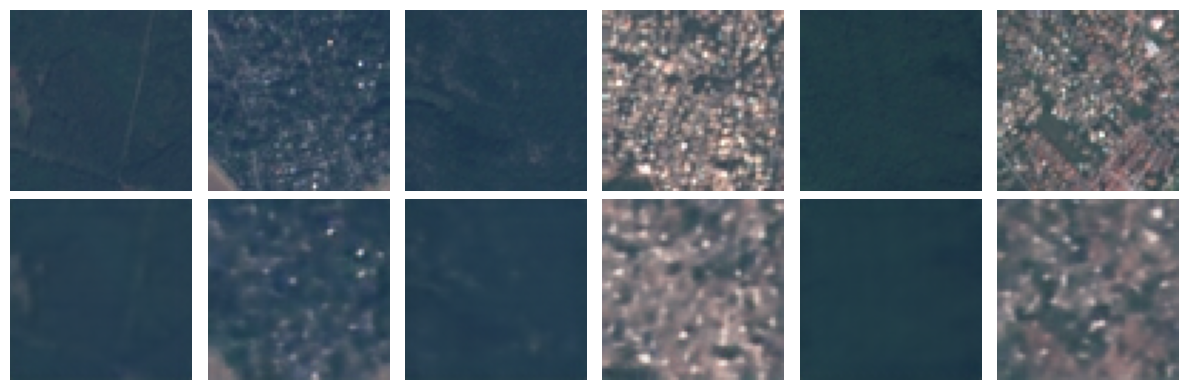


--- Reconstructions SoftShare ---


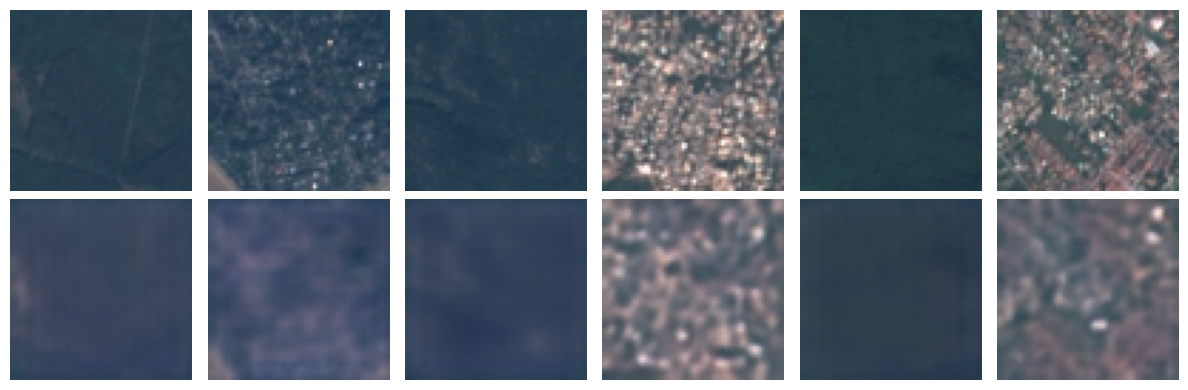

In [56]:
print("\n--- Reconstructions MTL ---")
show_reconstructions(model_mtl, val_loader, recon_mtl, device, n=6)

print("\n--- Reconstructions SoftShare ---")
show_reconstructions(model_soft, val_loader, recon_soft, device, n=6)

In [72]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_latent_iid_ood(model, loader_iid, loader_ood, device, method="pca"):
    model.eval()
    feats, labels, domains = [], [], []

    with torch.no_grad():
        for x, y in loader_iid:
            x = x.to(device)
            z = model.shared(x).view(x.size(0), -1)
            feats.append(z.cpu())
            labels.extend(y.tolist())
            domains.extend(["IID"] * len(y))

        for x, y in loader_ood:
            x = x.to(device)
            z = model.shared(x).view(x.size(0), -1)
            feats.append(z.cpu())
            labels.extend(y.tolist())
            domains.extend(["OOD"] * len(y))

    X = torch.cat(feats).numpy()
    y = np.array(labels)
    d = np.array(domains)

    reducer = PCA(n_components=2) if method == "pca" else TSNE(n_components=2, perplexity=30, random_state=42)
    X2D = reducer.fit_transform(X)

    plt.figure(figsize=(6,5))

    color_map = np.array(['green' if c == 0 else 'orange' for c in y])

    mask_iid = (d == "IID")
    plt.scatter(
        X2D[mask_iid, 0], X2D[mask_iid, 1],
        c=color_map[mask_iid],
        s=12, marker='o', alpha=0.35, label="IID"
    )

    mask_ood = (d == "OOD")
    plt.scatter(
        X2D[mask_ood, 0], X2D[mask_ood, 1],
        c=color_map[mask_ood],
        s=22, marker='s', alpha=0.9, edgecolors='black', linewidths=0.3, label="OOD"
    )

    plt.title(f"Espace latent partagé ({method.upper()}) – IID vs OOD")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend(handles=[
        plt.Line2D([0],[0], marker='o', color='w', label='Forest', markerfacecolor='green', markersize=6),
        plt.Line2D([0],[0], marker='o', color='w', label='Residential', markerfacecolor='orange', markersize=6),
        plt.Line2D([0],[0], marker='o', color='w', label='IID (cercles)', markerfacecolor='green', alpha=0.2, markersize=5),
        plt.Line2D([0],[0], marker='s', color='w', label='OOD (carrés)', markerfacecolor='orange', alpha=1.0, markersize=5)
    ], loc='best')
    plt.tight_layout()
    plt.show()


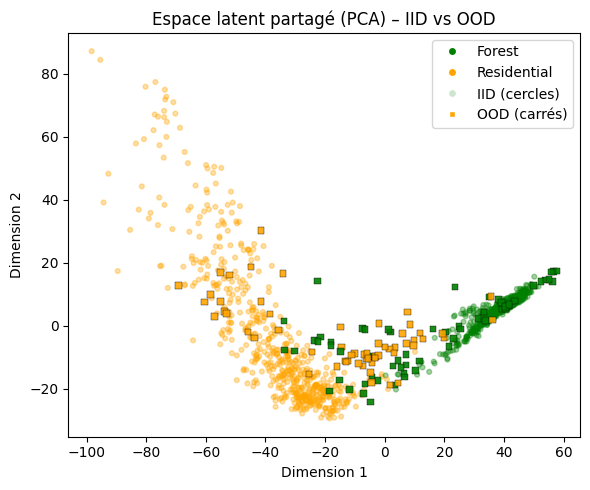

In [71]:
visualize_latent_iid_ood(model_mtl, val_loader, ood_loader, device, method="pca")

In [77]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_latent_shared_vs_head(model, loader_iid, loader_ood, device, method="pca"):
    model.eval()
    feats_shared, feats_head, labels, domains = [], [], [], []

    with torch.no_grad():
        # IID
        for x, y in loader_iid:
            x = x.to(device)
            z_shared = model.shared(x)
            z_head_in = model.cls_head[0:3](z_shared)  
            z_shared = z_shared.view(x.size(0), -1)
            z_head_in = z_head_in.view(x.size(0), -1)
            feats_shared.append(z_shared.cpu())
            feats_head.append(z_head_in.cpu())
            labels.extend(y.tolist())
            domains.extend(["IID"] * len(y))

        # OOD
        for x, y in loader_ood:
            x = x.to(device)
            z_shared = model.shared(x)
            z_head_in = model.cls_head[0:3](z_shared)
            z_shared = z_shared.view(x.size(0), -1)
            z_head_in = z_head_in.view(x.size(0), -1)
            feats_shared.append(z_shared.cpu())
            feats_head.append(z_head_in.cpu())
            labels.extend(y.tolist())
            domains.extend(["OOD"] * len(y))

    Xs = torch.cat(feats_shared).numpy()
    Xh = torch.cat(feats_head).numpy()
    y = np.array(labels)
    d = np.array(domains)

    reducer = PCA(n_components=2) if method == "pca" else TSNE(n_components=2, random_state=42, perplexity=30)
    Xs_2D = reducer.fit_transform(Xs)
    Xh_2D = reducer.fit_transform(Xh)

    color_map = np.array(['green' if c == 0 else 'orange' for c in y])

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    mask_iid = (d == "IID")
    mask_ood = (d == "OOD")
    plt.scatter(Xs_2D[mask_iid,0], Xs_2D[mask_iid,1],
                c=color_map[mask_iid], s=12, alpha=0.35, marker='o', label='IID')
    plt.scatter(Xs_2D[mask_ood,0], Xs_2D[mask_ood,1],
                c=color_map[mask_ood], s=22, alpha=0.9, marker='s',
                edgecolors='black', linewidths=0.3, label='OOD')
    plt.title("Espace latent partagé (shared)")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")

    plt.subplot(1,2,2)
    plt.scatter(Xh_2D[mask_iid,0], Xh_2D[mask_iid,1],
                c=color_map[mask_iid], s=12, alpha=0.35, marker='o', label='IID')
    plt.scatter(Xh_2D[mask_ood,0], Xh_2D[mask_ood,1],
                c=color_map[mask_ood], s=22, alpha=0.9, marker='s',
                edgecolors='black', linewidths=0.3, label='OOD')
    plt.title("Espace latent avant FC (cls_head input)")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")

    plt.legend(handles=[
        plt.Line2D([0],[0], marker='o', color='w', label='Forest', markerfacecolor='green', markersize=6),
        plt.Line2D([0],[0], marker='o', color='w', label='Residential', markerfacecolor='orange', markersize=6),
        plt.Line2D([0],[0], marker='o', color='w', label='IID (cercles)', markerfacecolor='green', alpha=0.3, markersize=5),
        plt.Line2D([0],[0], marker='s', color='w', label='OOD (carrés)', markerfacecolor='orange', alpha=1.0, markersize=5)
    ], loc='lower right')
    plt.tight_layout()
    plt.show()


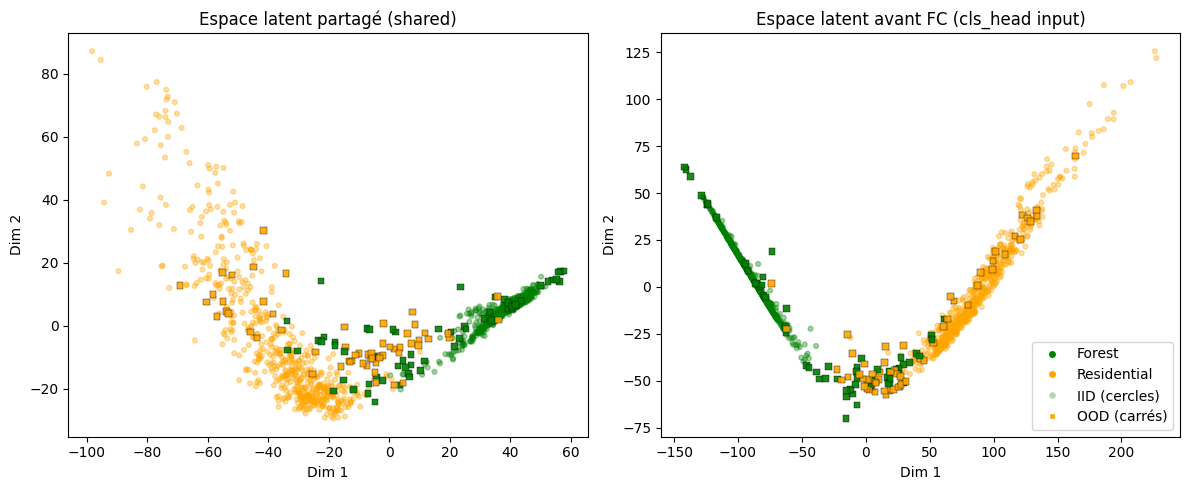

In [78]:
visualize_latent_shared_vs_head(model_mtl, val_loader, ood_loader, device, method="pca")